In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH
%load_ext autoreload
%autoreload 2
%matplotlib widget

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import divergence
from pinns.krr import krr, rbf
from pinns.elm import elm
from pinns.pde import poisson_dirichlet_qp_mc, poisson_dirichlet_ecqp_mc
from scipy.stats.qmc import Sobol

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)

In [38]:
a = 1.
b = 1.
c = 0.1
domain = Hypercube((-a / 2, -b / 2, -c / 2), (a / 2, b / 2, c / 2))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=4).random_base2(10))
x_bnd = domain.transform_bnd(x_bnd)


In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-a/2, a/2, N)
    z = np.linspace(-c/2, c/2, N)

    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)


def plot_model(model, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax)



In [40]:
weights = array(Sobol(4, seed=12345).random_base2(9))
W_elm = pi * (weights[:, :3] * 2 - 1)
b_elm = pi * (weights[:, 3] * 2 - 1)
W_elm = (weights[:, :3] * 2 - 1)
b_elm = (weights[:, 3] * 2 - 1)


def normalize(x):
    return x / norm(x, axis=-1, keepdims=True)

m_const = lambda x: array([0., 0., 1.])

def m_flower(x):
    mx = 1 / a * x[..., 0] * x[..., 2]
    my = 1 / c * x[..., 1] * x[..., 2] + 1 / b ** 3 * x[..., 1] ** 3 * x[..., 2] ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return normalize(mag)

def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(x ** 2 + y ** 2)
    k = r**2 / rc**2
    mx = - y / r * sqrt(1 - exp(-4*k))
    my = x / r * sqrt(1 - exp(-4*k))
    mz = exp(-2*k)
    mag = stack([mx, my, mz], axis=-1)
    return normalize(mag)


m = m_const #m_vortex
f = lambda x: -divergence(m)(x)
def l(x):
    x, y, z = x
    return -(x - a / 2) * (x + a / 2) * (y - b / 2) * (y + b / 2) * (z - c / 2) * (z + c / 2)
#n = lambda x: normalize(-grad(l)(x))

def n(x):
    x, y, z = x
    x1 = jnp.where(x == -a/2, -1., 0.)
    x2 = jnp.where(x == a/2, 1., 0.)
    nx = x1 + x2
    y1 = jnp.where(y == -b/2, -1., 0.)
    y2 = jnp.where(y == b/2, 1., 0.)
    ny = y1 + y2
    z1 = jnp.where(z == -c/2, -1., 0.)
    z2 = jnp.where(z == c/2, 1., 0.)
    nz = z1 + z2
    return array([nx, ny, nz])


h = lambda x: tanh(W_elm @ x + b_elm)
#h = lambda x: exp(-10 * (W_elm @ x + b_elm) ** 2)
u = lambda x: l(x) * h(x)
# #u = lambda x: l(x) * exp(-1 * (W @ x + b)**2)
g1 = lambda x: 0.

phi1 = poisson_dirichlet_qp_mc(u, g1, x_dom, f, tol=1e-9, maxiter=4000)

# u = lambda x: h(x)
# phi1 = poisson_dirichlet_ecqp_mc(u, f, x_dom, x_bnd, vmap(g1)(x_bnd), tol=1e-10, maxiter=20000, refine_regularization=2, refine_maxiter=30)

In [17]:
def phi2_solution(x, x_bnd):
    eps = 1e-14
    def g(y):
        return dot(m(y), n(y)) - dot(grad(phi1)(y), n(y))
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return (2 * a * b + 2 * b * c + 2 * a * c) / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

In [18]:
_x_bnd = array(Sobol(2, seed=123).random_base2(17))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [19]:
X = concatenate([x_bnd, x_dom])
g2 = elm(x_bnd, phi_bnd, W_elm, b_elm)
phi2 = poisson_dirichlet_qp_mc(u, g2, x_dom)

# phi2 = poisson_dirichlet_ecqp_mc(u, lambda x: 0, x_dom, x_bnd, phi_bnd, tol=1e-12, maxiter=30000, refine_regularization=2, refine_maxiter=30)


phi_nn = lambda x: phi1(x) + phi2(x)

In [20]:
def ed(model, x):
    Ms = 1.
    mag = vmap(m)(x)
    H = lambda x: -grad(model)(x)
    e = lambda x: dot(m(x), H(x)) 
    return -Ms * (a * b * c) / 2 * jnp.sum(vmap(e)(x)) / len(x)

In [21]:
ed(phi_nn, x_dom)

DeviceArray(0.02117491, dtype=float64)

In [183]:
print(f"{abs(ed(phi_nn, x_dom) - 1.528e-01):.4e}")

1.3163e-01


In [25]:
print(f"{abs(2.189e-02 - 2.160e-02):.4e}")

2.9000e-04


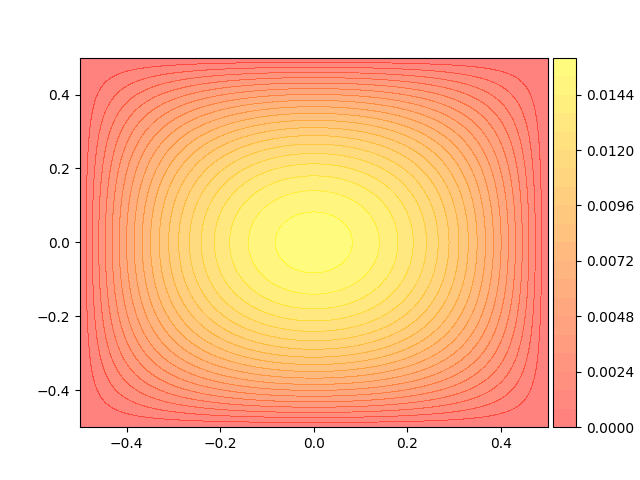

In [57]:
plot_model(vmap(l))

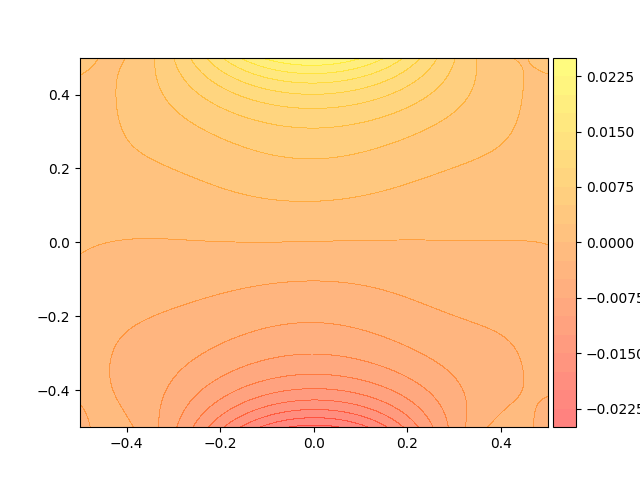

In [58]:
plot_model(vmap(phi_nn))

(-0.55, 0.55, -0.55, 0.55)

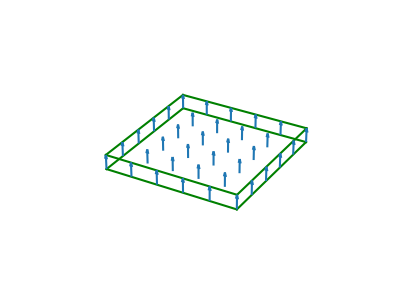

In [54]:
from itertools import combinations, product
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1,1,1, projection='3d')

X = jnp.meshgrid(np.arange(-a/2, a/2+0.01, 0.2),
                 np.arange(-b/2, b/2+0.01, 0.2),
                 np.arange(-c/2, c/2+0.01, 0.2))

X = jnp.stack(X, axis=-1)
M = m(X)
r1 = [-a/2, a/2]
r2 = [-b/2, b/2]
r3 = [-c/2, c/2]
for s, e in combinations(np.array(list(product(r1, r2, r3))), 2):
   if not (
    np.sum(np.abs(s-e)) < 1.0 or np.sum(np.abs(s-e)) > 1.01
    ):
    
    ax.plot3D(*zip(s, e), color="green")

ax.set_box_aspect((10, 10, 1))
ax.quiver(
    X[..., 0], 
    X[..., 1], 
    X[..., 2], 
    M[..., 0], 
    M[..., 1], 
    M[..., 2], 
    length=0.1)
ax.axis('off')

# ax2 = fig.add_subplot(1,2,2)
# ax2.set_xlim([-a/2, a/2])
# ax2.set_xlabel("$x$")
# ax2.set_ylabel("$z$")
# ax2.set_ylim([-c/2, c/2])
# ax2.set_aspect('equal', 'box')
# plot_model(vmap(phi_nn), ax2)

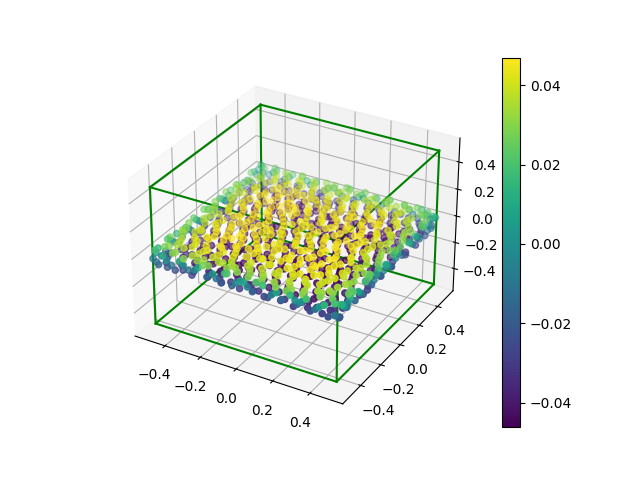

In [30]:

ax = plt.figure().add_subplot(projection='3d')

r = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
   if np.sum(np.abs(s-e)) == r[1]-r[0]:
      ax.plot3D(*zip(s, e), color="green")

p = ax.scatter(x_bnd[:, 0], x_bnd[:, 1], x_bnd[:, 2], c=vmap(phi2)(x_bnd))
plt.colorbar(p)
